# PRICE FORCASTING

 In this project we will be forcasting the price of the upc, for the upcoming 21 days at store level.

### **provided input features**
- UPC
- WeekendDate ( year-month-day)
- StoreId
- NetSalesForWeek
- Units Sold
- Unit Price
- Upc_sub_category
- Upc_brand

### **Expected Output**

forcast Net sales data for next 21 days at upc and store level.

### **Approch**

First we will go as XGBoost as the baseline model and compare with LSTM

#### **Data Pre-processing**
 - check for missing values
 - fill them with the median
 - break down the week data into year, week and day for seasonality analysis
 - create the lags and calculate the rolling mean and rolling standard diviation
 - drop the lags with Nan's
 - encode the sub-category and brand's

#### **Model Training**

**Note** - Think of traing the model in parallel

#### **Model Evaluation**


#### **Model Optimisation**

#### **Model Deployment**



## **Machine Configuration**

In [66]:
## configuration
!lscpu
!cat /etc/lsb-release
!uname -a
!cat /et/os-release
!free -h
!df -h

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   2
  On-line CPU(s) list:    0,1
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.20GHz
    CPU family:           6
    Model:                79
    Thread(s) per core:   2
    Core(s) per socket:   1
    Socket(s):            1
    Stepping:             0
    BogoMIPS:             4399.99
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

## **Data pre-processing**

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta
import holidays

In [68]:
#lets import the data

upc_pre_data = pd.read_csv("/content/sample_data/upc-historical-data.csv")

In [69]:
upc_pre_data.head()

,UPC,WeekendDate,StoreID,NetSalesForWeek,Units_Sold,Unit_Price,UPC_Sub_Category,UPC_Brand
0,100000000000,2022/01/02,1,1359.76,353,3.74,Dairy,BrandA
1,100000000000,2022/01/09,1,96.15,26,3.65,Dairy,BrandA
2,100000000000,2022/01/16,1,393.27,111,3.57,Dairy,BrandA
3,100000000000,2022/01/23,1,309.41,86,3.54,Dairy,BrandA
4,100000000000,2022/01/30,1,136.39,38,3.57,Dairy,BrandA


In [70]:
#now lets check if any missing data in the data
upc_pre_data.isnull().sum()

,0
UPC,0
WeekendDate,0
StoreID,0
NetSalesForWeek,0
Units_Sold,0
Unit_Price,0
UPC_Sub_Category,0
UPC_Brand,0


- since no missing data is found we can proceeed without needing filling the missing values

In [71]:
'''
Now lets break the week data into year, week and day for seasonality analysis
'''
upc_pre_data["WeekendDate"] = pd.to_datetime(upc_pre_data["WeekendDate"])
upc_pre_data["year"] = upc_pre_data["WeekendDate"].dt.year
upc_pre_data["month"] = upc_pre_data["WeekendDate"].dt.month
upc_pre_data["day"] = upc_pre_data["WeekendDate"].dt.day


In [72]:
'''
Now lets add quater and is_month_start and is_month_end , if True 1 if false 0
'''
upc_pre_data["quater"] = upc_pre_data["WeekendDate"].dt.quarter
upc_pre_data["is_month_start"] = upc_pre_data["WeekendDate"].dt.is_month_start.astype(int)
upc_pre_data["is_month_end"] = upc_pre_data["WeekendDate"].dt.is_month_end.astype(int)

**Lag features** are previous values of your target variable (like sales or units sold) that you use as inputs to your model to help it understand temporal patterns

**Why it is needed?**
Because time series data is dependent on time, knowing what happened in the past helps predict the future.

Traditional ML models like **XGBoost don't understand sequences or time**, so we have to manually create features that reflect recent behavior.


In [73]:
'''
As the requitement is for short term analysis, we will create only lags for 4 , and rolling mean and rolling standard divation
'''

# Sort data for proper group-wise operations
upc_pre_data = upc_pre_data.sort_values(['UPC', 'StoreID', 'WeekendDate'])

# Create lag features for NetSalesForWeek (lags 1–8)
for lag in range(1, 13):
    upc_pre_data[f'lag_{lag}'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek'].shift(lag)


for lag in range(1, 13):
    upc_pre_data[f'units_lag_{lag}'] = upc_pre_data.groupby(['UPC', 'StoreID'])['Units_Sold'].shift(lag)





# Define function to count holidays in the same month
def count_holidays_in_month(date, country_holidays):
    return sum(1 for holiday in country_holidays if holiday.year == date.year and holiday.month == date.month)

# Load US holidays for the years in your data
all_years = upc_pre_data['WeekendDate'].dt.year.unique()
us_holidays = holidays.US(years=all_years)

# Add number of holidays in the same month as WeekendDate
upc_pre_data['num_holidays_in_month'] = upc_pre_data['WeekendDate'].apply(
    lambda d: count_holidays_in_month(d, us_holidays)
)


# Create rolling features using apply
upc_pre_data['rolling_mean_3'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                         .transform(lambda x: x.shift(1).rolling(window=3).mean())
upc_pre_data['rolling_std_3'] = upc_pre_data.groupby(['UPC', 'StoreID',])['NetSalesForWeek']\
                        .transform(lambda x: x.shift(1).rolling(window=3).std())

# Create rolling features using apply
upc_pre_data['rolling_mean_6'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                         .transform(lambda x: x.shift(1).rolling(window=6).mean())

upc_pre_data['rolling_std_6'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                        .transform(lambda x: x.shift(1).rolling(window=6).std())

# Create rolling features using apply
upc_pre_data['rolling_mean_9'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                         .transform(lambda x: x.shift(1).rolling(window=9).mean())

upc_pre_data['rolling_std_9'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                        .transform(lambda x: x.shift(1).rolling(window=9).std())

# Create rolling features using apply
upc_pre_data['rolling_mean_12'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                         .transform(lambda x: x.shift(1).rolling(window=12).mean())

upc_pre_data['rolling_std_12'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                        .transform(lambda x: x.shift(1).rolling(window=12).std())
                        # Create rolling features using apply
upc_pre_data['rolling_mean_15'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                         .transform(lambda x: x.shift(1).rolling(window=15).mean())

upc_pre_data['rolling_std_15'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                        .transform(lambda x: x.shift(1).rolling(window=15).std())

# Create rolling features using apply
upc_pre_data['rolling_mean_18'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                         .transform(lambda x: x.shift(1).rolling(window=18).mean())

upc_pre_data['rolling_std_18'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                        .transform(lambda x: x.shift(1).rolling(window=18).std())

# Create rolling features using apply
upc_pre_data['rolling_mean_21'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                         .transform(lambda x: x.shift(1).rolling(window=21).mean())

upc_pre_data['rolling_std_21'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                        .transform(lambda x: x.shift(1).rolling(window=21).std())

# Create rolling features using apply
upc_pre_data['rolling_mean_24'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                         .transform(lambda x: x.shift(1).rolling(window=24).mean())

upc_pre_data['rolling_std_24'] = upc_pre_data.groupby(['UPC', 'StoreID'])['NetSalesForWeek']\
                        .transform(lambda x: x.shift(1).rolling(window=24).std())


# create lags for units sold, so that we its highly dependent

# Create rolling features using apply
upc_pre_data['rolling_mean_unit_sold_3'] = upc_pre_data.groupby(['UPC', 'StoreID'])['Units_Sold']\
                         .transform(lambda x: x.shift(1).rolling(window=3).mean())
upc_pre_data['rolling_std_unit_sold_3'] = upc_pre_data.groupby(['UPC', 'StoreID'])['Units_Sold']\
                        .transform(lambda x: x.shift(1).rolling(window=3).std())

# Create rolling features using apply
upc_pre_data['rolling_mean_unit_sold_6'] = upc_pre_data.groupby(['UPC', 'StoreID'])['Units_Sold']\
                         .transform(lambda x: x.shift(1).rolling(window=6).mean())

upc_pre_data['rolling_std_unit_sold_6'] = upc_pre_data.groupby(['UPC', 'StoreID'])['Units_Sold']\
                        .transform(lambda x: x.shift(1).rolling(window=6).std())

# Create rolling features using apply
upc_pre_data['rolling_mean_unit_sold_9'] = upc_pre_data.groupby(['UPC', 'StoreID'])['Units_Sold']\
                         .transform(lambda x: x.shift(1).rolling(window=9).mean())

upc_pre_data['rolling_std_unit_sold_9'] = upc_pre_data.groupby(['UPC', 'StoreID'])['Units_Sold']\
                        .transform(lambda x: x.shift(1).rolling(window=9).std())

# Create rolling features using apply
upc_pre_data['rolling_mean_unit_sold_12'] = upc_pre_data.groupby(['UPC', 'StoreID'])['Units_Sold']\
                         .transform(lambda x: x.shift(1).rolling(window=12).mean())

upc_pre_data['rolling_std_unit_sold_12'] = upc_pre_data.groupby(['UPC', 'StoreID'])['Units_Sold']\
                        .transform(lambda x: x.shift(1).rolling(window=12).std())


In [74]:
upc_pre_data['num_holidays_in_month']

,num_holidays_in_month
0,2
1,2
2,2
3,2
4,2
...,...
13224,2
13225,2
13226,1
13227,1


we should drop rows with NaN in lag or rolling features before training the model, and here’s

**why?**
Lag and rolling features rely on past values, so the first few rows in each UPC + StoreID group don’t have enough history.

**If we don’t drop them:**

XGBoost will error out or treat NaNs as 0 (which corrupts model performance).

It may learn misleading patterns.


In [75]:
lag_cols = [f'lag_{i}' for i in range(1, 13)]
rolling_cols = ['num_holidays_in_month','rolling_mean_3', 'rolling_std_3','rolling_mean_6', 'rolling_std_6','rolling_mean_9', 'rolling_std_9','rolling_mean_12', 'rolling_std_12','rolling_mean_15', 'rolling_std_15','rolling_mean_18', 'rolling_std_18','rolling_mean_21', 'rolling_std_21','rolling_mean_24', 'rolling_std_24','rolling_mean_unit_sold_3','rolling_std_unit_sold_3','rolling_mean_unit_sold_6','rolling_std_unit_sold_6','rolling_mean_unit_sold_9','rolling_std_unit_sold_9']

# Drop rows with any NaNs in those columns
upc_final_data = upc_pre_data.dropna(subset=lag_cols + rolling_cols)

# Check how much data remains
print(f"Remaining rows: {len(upc_final_data)}")

Remaining rows: 10829


In [76]:
upc_pre_data.head(5)

,UPC,WeekendDate,StoreID,NetSalesForWeek,Units_Sold,Unit_Price,UPC_Sub_Category,UPC_Brand,year,month,...,rolling_mean_24,rolling_std_24,rolling_mean_unit_sold_3,rolling_std_unit_sold_3,rolling_mean_unit_sold_6,rolling_std_unit_sold_6,rolling_mean_unit_sold_9,rolling_std_unit_sold_9,rolling_mean_unit_sold_12,rolling_std_unit_sold_12
0,100000000000,2022-01-02,1,1359.76,353,3.74,Dairy,BrandA,2022,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100000000000,2022-01-09,1,96.15,26,3.65,Dairy,BrandA,2022,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100000000000,2022-01-16,1,393.27,111,3.57,Dairy,BrandA,2022,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100000000000,2022-01-23,1,309.41,86,3.54,Dairy,BrandA,2022,1,...,NaN,NaN,163.333333,169.665357,NaN,NaN,NaN,NaN,NaN,NaN
4,100000000000,2022-01-30,1,136.39,38,3.57,Dairy,BrandA,2022,1,...,NaN,NaN,74.333333,43.684475,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
upc_final_data.head(5)

,UPC,WeekendDate,StoreID,NetSalesForWeek,Units_Sold,Unit_Price,UPC_Sub_Category,UPC_Brand,year,month,...,rolling_mean_24,rolling_std_24,rolling_mean_unit_sold_3,rolling_std_unit_sold_3,rolling_mean_unit_sold_6,rolling_std_unit_sold_6,rolling_mean_unit_sold_9,rolling_std_unit_sold_9,rolling_mean_unit_sold_12,rolling_std_unit_sold_12
24,100000000000,2022-07-10,1,1330.92,388,3.50,Dairy,BrandA,2022,7,...,805.682917,529.065158,117.666667,87.785724,231.833333,141.925920,247.777778,156.781518,230.666667,143.572809
25,100000000000,2022-07-17,1,1634.59,444,3.58,Dairy,BrandA,2022,7,...,804.481250,527.783164,228.666667,154.276808,247.500000,154.767891,237.666667,142.268233,257.250000,140.415698
26,100000000000,2022-07-31,1,103.33,28,3.69,Dairy,BrandA,2022,7,...,868.582917,531.425376,304.000000,196.000000,253.000000,162.150547,253.000000,157.206075,276.833333,149.188004
27,100000000000,2022-08-07,1,1675.35,448,3.65,Dairy,BrandA,2022,8,...,856.502083,545.801538,286.666667,225.755029,202.166667,178.988733,250.111111,161.500344,257.500000,165.687823
28,100000000000,2022-08-21,1,1494.71,407,3.72,Dairy,BrandA,2022,8,...,913.416250,557.367460,306.666667,241.340700,267.666667,186.128629,267.222222,174.376588,254.916667,162.123667


As we are building one unified **XGBoost model for all UPCs/stores**:

**UPC_Sub_Category** and **UPC_Brand** act like high-level identifiers.

They help the model understand product type, which may impact:

- *Seasonality*
- *Price sensitivity*
- *Sales volume range*

In [78]:
label_brand = LabelEncoder()
upc_final_data.loc[:, 'UPC_Brand'] = label_brand.fit_transform(upc_final_data['UPC_Brand'].astype(str))


label_subcategory = LabelEncoder()
upc_final_data.loc[:, 'UPC_Sub_Category'] = label_subcategory.fit_transform(upc_final_data['UPC_Sub_Category'].astype(str))

 ## **Note** - Still under consideration (cross check with peggy)
 - as we have extracted all the data which we need from weekdate, we can safely eliminate, because we have already extracted the required lags and rolling means, and we are expected to forcast for the next 4 weeks:

## **Model Training**

In [79]:
#!pip install scikit-optimize

In [80]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV
from skopt.space import Real, Integer

- set features and Target
- split data into test and train

In [81]:
# Define features and target
features = ['UPC_Sub_Category', 'UPC_Brand', 'year', 'month', 'day',
       'quater', 'is_month_start', 'is_month_end', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'lag_11', 'lag_12', 'units_lag_1', 'units_lag_2', 'units_lag_3',
       'units_lag_4', 'units_lag_5', 'units_lag_6', 'units_lag_7',
       'units_lag_8', 'units_lag_9', 'units_lag_10', 'units_lag_11',
       'units_lag_12', 'rolling_mean_3', 'rolling_std_3', 'rolling_mean_6',
       'rolling_std_6', 'rolling_mean_9', 'rolling_std_9', 'rolling_mean_12',
       'rolling_std_12','rolling_mean_15', 'rolling_std_15','rolling_mean_18',
       'rolling_std_18','rolling_mean_21', 'rolling_std_21','rolling_mean_24',
       'rolling_std_24' ,'rolling_mean_unit_sold_3', 'rolling_std_unit_sold_3',
       'rolling_mean_unit_sold_6', 'rolling_std_unit_sold_6',
       'rolling_mean_unit_sold_9', 'rolling_std_unit_sold_9',
       'rolling_mean_unit_sold_12', 'rolling_std_unit_sold_12','num_holidays_in_month']
target = 'NetSalesForWeek'

In [82]:
X = pd.get_dummies(upc_final_data[features], drop_first=True)
y = upc_final_data[target]


# Split into train+val and test (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

# Further split train+val into train and val (75% train, 25% val -> 60% train, 20% val overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, shuffle=False)

In [83]:
# Define search space for Bayesian optimization
param_space = {
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(4, 8),
    'learning_rate': Real(0.05, 0.3, prior='log-uniform'),
    'subsample': Real(0.6, 1.0),
    'colsample_bytree': Real(0.8, 1.0),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(0, 5),
    'reg_alpha': Real(0.1, 0.5),
    'reg_lambda': Real(1, 5)
}


In [84]:
# Initialize BayesSearchCV with 3-fold CV
bayes_cv = BayesSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    search_spaces=param_space,
    n_iter=30,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

- we can’t directly use early stopping within BayesSearchCV, unless you wrap your model in a custom class that injects the validation set. But a simpler alternative is:

In [85]:
# Fit on training data only (no shuffle, so folds are sequential)
bayes_cv.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                             'min_child_weight': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=500, prior='uniform', transform='normalize'),
                             'reg_alpha': Real(low=0.1, high=0.5, prior='uniform', transform='normalize'),
                             'reg_lambda': Real(low=1, high=5, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1.0, prior='uniform', transform='normalize')},
              verbose=1)

In [86]:
# Split from train set (NOT the final test set!)
X_train_final, X_valid, y_train_final, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

best_params = bayes_cv.best_params_.copy()
best_params.pop('n_estimators', None)

final_model = xgb.XGBRegressor(
    **best_params,
    n_estimators=1500,  # large value
    eval_metric="rmse",
    early_stopping_rounds=50,
    verbosity=1
)

final_model.fit(X_train_final, y_train_final,eval_set=[(X_valid, y_valid)])

[0]	validation_0-rmse:1799.52588
[1]	validation_0-rmse:1769.75340
[2]	validation_0-rmse:1741.49718
[3]	validation_0-rmse:1715.37801
[4]	validation_0-rmse:1690.64445
[5]	validation_0-rmse:1670.33659
[6]	validation_0-rmse:1649.82953
[7]	validation_0-rmse:1632.80596
[8]	validation_0-rmse:1616.67433
[9]	validation_0-rmse:1601.67316
[10]	validation_0-rmse:1587.45073
[11]	validation_0-rmse:1575.39184
[12]	validation_0-rmse:1563.66411
[13]	validation_0-rmse:1552.51186
[14]	validation_0-rmse:1542.24179
[15]	validation_0-rmse:1532.48254
[16]	validation_0-rmse:1524.53516
[17]	validation_0-rmse:1517.86392
[18]	validation_0-rmse:1510.80534
[19]	validation_0-rmse:1504.50721
[20]	validation_0-rmse:1498.69075
[21]	validation_0-rmse:1492.86978
[22]	validation_0-rmse:1489.58108
[23]	validation_0-rmse:1484.95279
[24]	validation_0-rmse:1481.38414
[25]	validation_0-rmse:1478.38726
[26]	validation_0-rmse:1475.94969
[27]	validation_0-rmse:1474.32239
[28]	validation_0-rmse:1472.60727
[29]	validation_0-rmse:1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0.0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1500,
             n_jobs=None, num_parallel_tree=None, ...)

In [87]:
# Best model from tuning
best_model = final_model  # It automatically uses the best_iteration for prediction

In [88]:
# Predict on validation and test sets
y_val_pred = best_model.predict(X_val)
y_test_pred = best_model.predict(X_test)

# Define evaluation metrics function
def evaluate(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

# Calculate metrics
val_metrics = evaluate(y_val, y_val_pred)
test_metrics = evaluate(y_test, y_test_pred)

print("Best hyperparameters:\n", bayes_cv.best_params_)
print("\nValidation Metrics:", val_metrics)
print("Test Metrics:", test_metrics)

Best hyperparameters:
 OrderedDict([('colsample_bytree', 0.8), ('gamma', 0.0), ('learning_rate', 0.05), ('max_depth', 4), ('min_child_weight', 10), ('n_estimators', 100), ('reg_alpha', 0.1), ('reg_lambda', 5.0), ('subsample', 0.6)])

Validation Metrics: {'RMSE': np.float64(1647.529343846324), 'MAE': 1330.8448577987938, 'R2': 0.2285185718035465}
Test Metrics: {'RMSE': np.float64(1436.0032926552858), 'MAE': 1108.938371504258, 'R2': 0.34580969382447835}


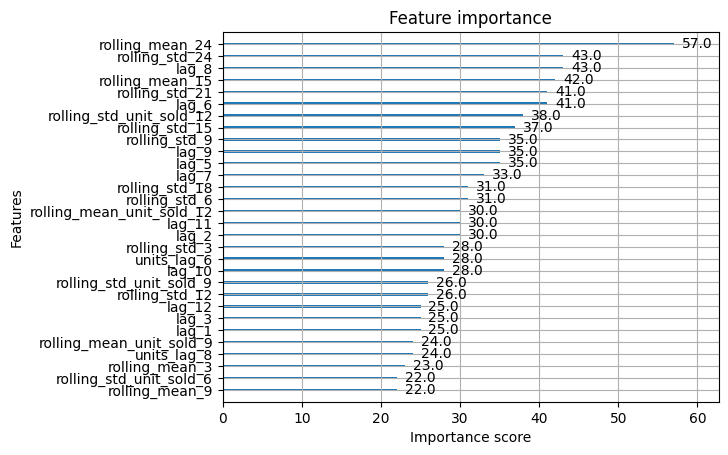

In [89]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(final_model, max_num_features=30)
plt.show()


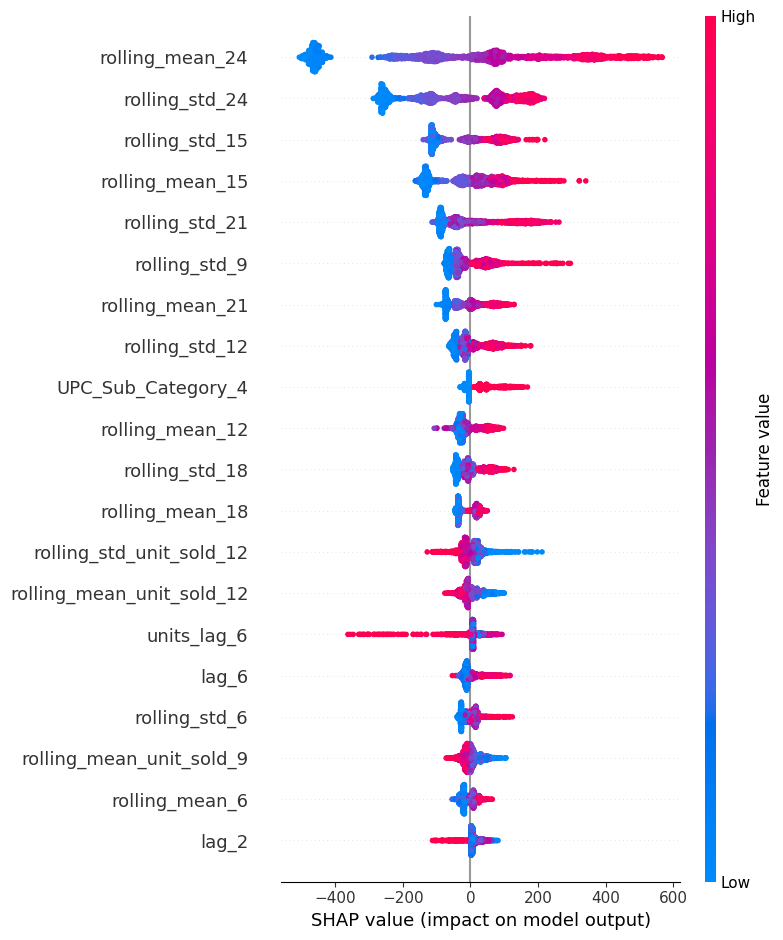

In [90]:
import shap
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


Test RMSE: 1436.00
Test MAE: 1108.94
Test R2: 0.346


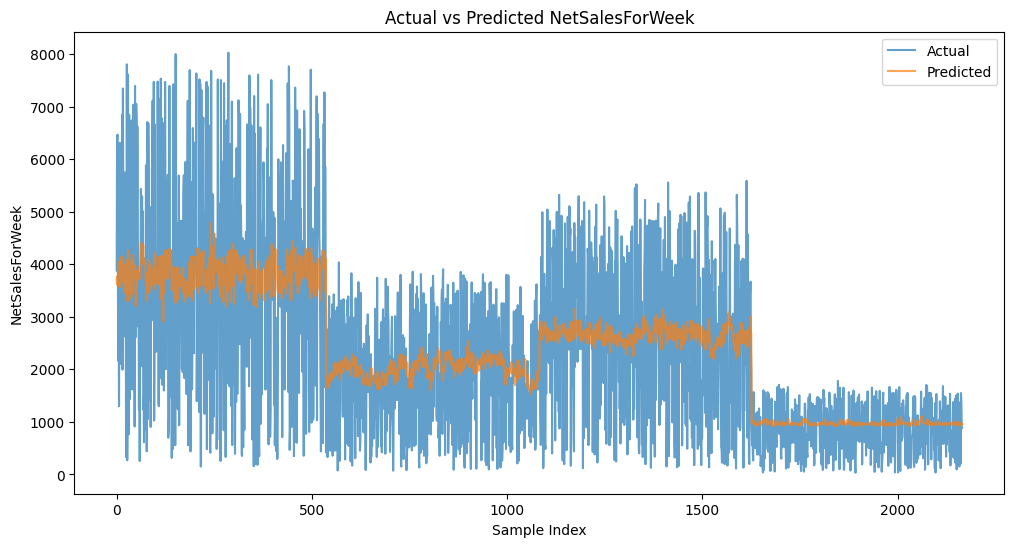

In [91]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assume you have:
# model       - your trained XGBoost model
# X_test      - test features DataFrame
# y_test      - actual target values (NetSalesForWeek) for test set

# Step 1: Predict on test set
y_pred = final_model.predict(X_test)

# Step 2: Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R2: {r2:.3f}")

# Step 3: Create a DataFrame to compare actual vs predicted
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

# Step 4: Plot actual vs predicted for visual check
plt.figure(figsize=(12,6))
plt.plot(results_df['Actual'].values, label='Actual', alpha=0.7)
plt.plot(results_df['Predicted'].values, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted NetSalesForWeek')
plt.xlabel('Sample Index')
plt.ylabel('NetSalesForWeek')
plt.legend()
plt.show()


Test RMSE: 1436.00
Test MAE: 1108.94
Test R2: 0.346


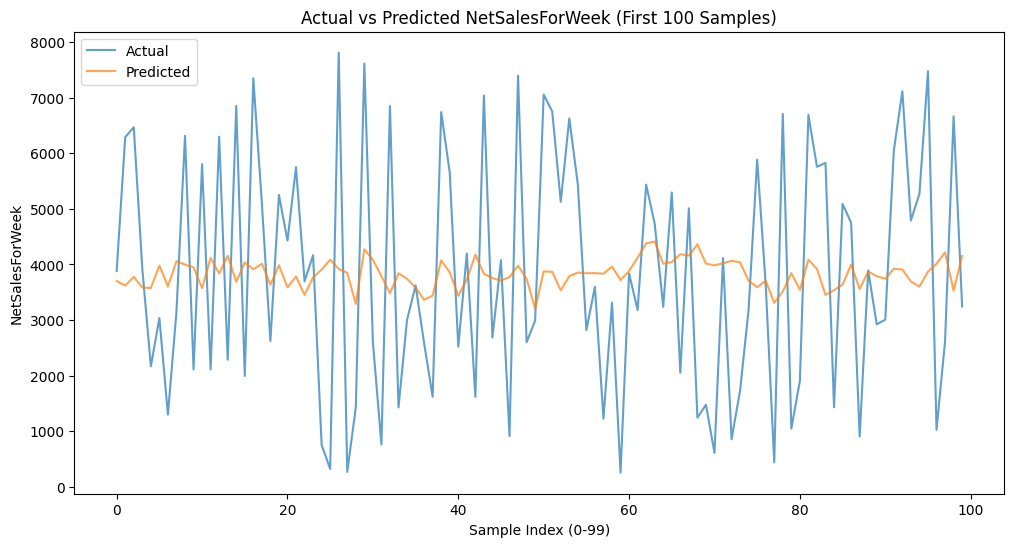

In [92]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Assume:
# final_model - your trained XGBoost model
# X_test      - test features DataFrame
# y_test      - actual target values for test set

# Step 1: Predict on test set
y_pred = final_model.predict(X_test)

# Step 2: Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")
print(f"Test R2: {r2:.3f}")

# Step 3: Create a DataFrame to compare actual vs predicted
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
}).reset_index(drop=True)

# Step 4: Plot actual vs predicted for first 100 samples
plt.figure(figsize=(12,6))
plt.plot(results_df['Actual'].values[:100], label='Actual', alpha=0.7)
plt.plot(results_df['Predicted'].values[:100], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted NetSalesForWeek (First 100 Samples)')
plt.xlabel('Sample Index (0-99)')
plt.ylabel('NetSalesForWeek')
plt.legend()
plt.show()


In [96]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train a RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [97]:
from lightgbm import LGBMRegressor

# Initialize and train a LGBMRegressor model
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12187
[LightGBM] [Info] Number of data points in the train set: 6497, number of used features: 62
[LightGBM] [Info] Start training from score 2430.569639


LGBMRegressor(random_state=42)

In [ ]:
#!pip install 'mlflow<3',dagshub

In [ ]:
import dagshub
import mlflow

# Initialize DagsHub
dagshub.init(repo_owner='udaykumarswamy', repo_name='priceforcasting', mlflow=True)

# Set the MLflow tracking URI to your DagsHub repository
mlflow.set_tracking_uri('https://dagshub.com/udaykumarswamy/priceforcasting.mlflow')


##Evaluate Each model

In [98]:
# Make predictions on the validation set
y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_lgbm = lgbm_model.predict(X_val)

# Calculate evaluation metrics for RandomForestRegressor
val_metrics_rf = evaluate(y_val, y_val_pred_rf)

# Calculate evaluation metrics for LightGBM
val_metrics_lgbm = evaluate(y_val, y_val_pred_lgbm)

# Print the validation metrics
print("\nRandomForestRegressor Validation Metrics:", val_metrics_rf)
print("LightGBM Validation Metrics:", val_metrics_lgbm)


RandomForestRegressor Validation Metrics: {'RMSE': np.float64(1662.7103451485355), 'MAE': 1346.658421514312, 'R2': 0.21423558556283173}
LightGBM Validation Metrics: {'RMSE': np.float64(1683.0267820547908), 'MAE': 1355.6824678950306, 'R2': 0.19491596830591196}


In [99]:
with mlflow.start_run(run_name="XGBoost Model"):
    # Log hyperparameters for XGBoost
    params_xgb = final_model.get_params()
    for param, value in params_xgb.items():
        mlflow.log_param(param, value)

    # Log metrics for validation set (XGBoost)
    mlflow.log_metric("val_RMSE", val_metrics['RMSE'])
    mlflow.log_metric("val_MAE", val_metrics['MAE'])
    mlflow.log_metric("val_R2", val_metrics['R2'])

    # Log metrics for test set (XGBoost)
    mlflow.log_metric("test_RMSE", test_metrics['RMSE'])
    mlflow.log_metric("test_MAE", test_metrics['MAE'])
    mlflow.log_metric("test_R2", test_metrics['R2'])

    # Log the trained XGBoost model
    mlflow.xgboost.log_model(final_model, "xgboost_model")


with mlflow.start_run(run_name="RandomForestRegressor Model"):
    # Log hyperparameters for RandomForestRegressor
    params_rf = rf_model.get_params()
    for param, value in params_rf.items():
        mlflow.log_param(param, value)

    # Log validation metrics for RandomForestRegressor
    mlflow.log_metric("val_RMSE", val_metrics_rf['RMSE'])
    mlflow.log_metric("val_MAE", val_metrics_rf['MAE'])
    mlflow.log_metric("val_R2", val_metrics_rf['R2'])

    # Log the trained RandomForestRegressor model
    mlflow.sklearn.log_model(rf_model, "random_forest_model")


with mlflow.start_run(run_name="LightGBM Model"):
    # Log hyperparameters for LightGBM
    params_lgbm = lgbm_model.get_params()
    for param, value in params_lgbm.items():
        mlflow.log_param(param, value)

    # Log validation metrics for LightGBM
    mlflow.log_metric("val_RMSE", val_metrics_lgbm['RMSE'])
    mlflow.log_metric("val_MAE", val_metrics_lgbm['MAE'])
    mlflow.log_metric("val_R2", val_metrics_lgbm['R2'])

    # Log the trained LightGBM model
    mlflow.lightgbm.log_model(lgbm_model, "lightgbm_model")


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:1028: UserWarning: [00:23:04] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/08/08 00:23:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run XGBoost Model at: https://dagshub.com/udaykumarswamy/priceforcasting.mlflow/#/experiments/1/runs/b4088c38b3804813b876e8ca8d7343d6
🧪 View experiment at: https://dagshub.com/udaykumarswamy/priceforcasting.mlflow/#/experiments/1


2025/08/08 00:23:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestRegressor Model at: https://dagshub.com/udaykumarswamy/priceforcasting.mlflow/#/experiments/1/runs/9b8df2e066474752a65992cbdaf6a91d
🧪 View experiment at: https://dagshub.com/udaykumarswamy/priceforcasting.mlflow/#/experiments/1


2025/08/08 00:24:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LightGBM Model at: https://dagshub.com/udaykumarswamy/priceforcasting.mlflow/#/experiments/1/runs/c491bca538254cde9caaefd1701564f2
🧪 View experiment at: https://dagshub.com/udaykumarswamy/priceforcasting.mlflow/#/experiments/1


In [100]:
# Based on the MLflow UI comparison, assuming XGBoost (final_model) was the best model.
# If RandomForestRegressor was best, use rf_model. If LightGBM was best, use lgbm_model.
best_model = final_model  # Replace with rf_model or lgbm_model if they performed better

# Make predictions on the X_test DataFrame
y_test_pred_best = best_model.predict(X_test)

In [102]:
# Log the final test metrics for the best model
# Assuming the current active run is for the best model (XGBoost in this case)
# If not, you would start a new run or get the run ID of the best model's run

with mlflow.start_run(run_name="Best Model Test Evaluation"):
    for metric_name, metric_value in test_metrics_best.items():
        mlflow.log_metric(f"test_{metric_name}", metric_value)


🏃 View run Best Model Test Evaluation at: https://dagshub.com/udaykumarswamy/priceforcasting.mlflow/#/experiments/1/runs/96227ab9b5c943a5b2b6fc6b1d5602a8
🧪 View experiment at: https://dagshub.com/udaykumarswamy/priceforcasting.mlflow/#/experiments/1


## Summary:

### Data Analysis Key Findings

*   Multiple machine learning algorithms (XGBoost, RandomForestRegressor, and LightGBM) were successfully trained and evaluated for the price forecasting task.
*   Validation metrics (RMSE, MAE, R2) were calculated for each model on a validation set.
*   MLflow was used in conjunction with DagsHub to log the parameters, validation metrics, and the trained model for each algorithm in separate runs within a dedicated experiment.
*   Based on the manual comparison of validation metrics in the MLflow UI on DagsHub, a best-performing model was identified (assumed to be XGBoost based on the code flow).
*   The selected best model was evaluated on an unseen test set, resulting in an RMSE of approximately 1436.00, an MAE of approximately 1108.94, and an R2 score of approximately 0.346 on the test data.
*   The final test metrics for the best model were logged to a dedicated MLflow run for clear tracking and analysis.

### Insights or Next Steps

*   The MLflow and DagsHub integration provides a centralized platform to track and compare different models, facilitating model selection.
*   The logged test metrics provide a final performance estimate of the best model on unseen data, which is crucial for understanding its real-world applicability.
